<font color='purple'><h1>Klasifikacija odgovora-eksperimenti
</h1></font>

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#ucitavanje biblioteka za MLp
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Concatenate, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

<h4>Predstavljanje izlaznih kategorija kao one-hot</h4>

In [3]:
X_train=pd.read_csv('df_train.csv')

In [4]:
question_types_train=(X_train[:5000].groupby("answer_type").count())["question_id"].sort_values(ascending=False)
question_types_test=(X_train[5000:7000].groupby("answer_type").count())["question_id"].sort_values(ascending=False)

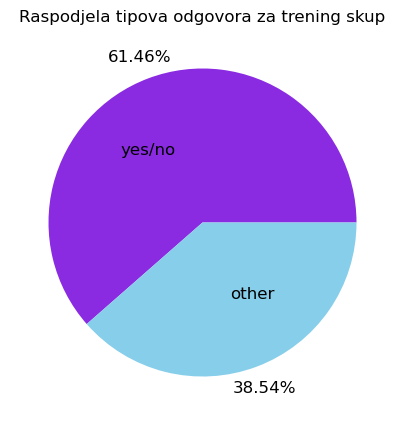

In [5]:
fig= plt.figure(figsize=(5,5))
plt.pie(question_types_train, labels = question_types_train.index,autopct='%.2f%%',
       pctdistance=1.15, labeldistance=0.5,colors=['blueviolet', 'skyblue', 'royalblue'],textprops={'fontsize': 12})
plt.title("Raspodjela tipova odgovora za trening skup")
plt.show() 

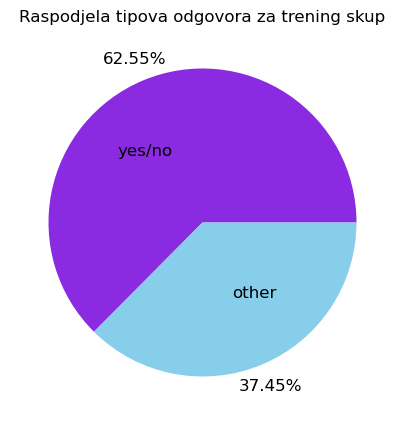

In [6]:
fig= plt.figure(figsize=(5,5))
plt.pie(question_types_test, labels = question_types_test.index,autopct='%.2f%%',
       pctdistance=1.15, labeldistance=0.5,colors=['blueviolet', 'skyblue', 'royalblue'],textprops={'fontsize': 12})
plt.title("Raspodjela tipova odgovora za trening skup")
plt.show() 

In [7]:
categories_train=(X_train[:5000]['multiple_choice_answer']).unique()

In [8]:
categories_test=(X_train[5000:7000]['multiple_choice_answer']).unique()

In [9]:
print('Broj klasa tj odgovora u trening skupu:',categories_train.shape[0])
print('Broj klasa tj odgovora u test skupu:',categories_test.shape[0])

Broj klasa tj odgovora u trening skupu: 100
Broj klasa tj odgovora u test skupu: 94


In [10]:
cat_to_int = {cat: i for i, cat in enumerate(categories_train)}
# Enkodovanje kategorija u integere
label_ints_train = [cat_to_int[label] for label in X_train[:5000]['multiple_choice_answer']]
label_ints_test = [cat_to_int[label] for label in X_train[5000:7000]['multiple_choice_answer']]

# Konvertovanje jedne int vrijednosti u one-hot vektor
one_hot_labels_train = to_categorical(label_ints_train, num_classes=len(categories_train))
one_hot_labels_test = to_categorical(label_ints_test, num_classes=len(categories_train))


In [11]:
#Klasifikacioni problem sa K=100 klasa tj. odgovora
print(one_hot_labels_train.shape)
print(one_hot_labels_test.shape)

(5000, 100)
(2000, 100)


In [12]:
labels_train=pd.DataFrame(one_hot_labels_train)
labels_test=pd.DataFrame(one_hot_labels_test)

In [13]:
#Cuvanje izlaznih labela u fajlove
labels_train.to_csv('one-hot-labels_train.csv',index=False)
labels_test.to_csv('one-hot-labels_test.csv',index=False)

<font color='blueviolet'><h2>MLP</h2></font>

In [45]:
#Postavljanje random na fiksno kako bi se mogli podesiti parametri prilikom vise pokretanja
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
#Definisanje arhitekture mlp 
#tanh je izabrana na onsovu literature
def mlp_architecture(concatenation_features):
    mlp_model = Sequential()
    mlp_model.add(Dense(1000, activation='tanh', input_shape=(concatenation_features.shape[1],)))
    mlp_model.add(Dropout(0.5))
    mlp_model.add(Dense(1000, activation='tanh'))
    mlp_model.add(Dropout(0.5))
    mlp_model.add(Dense(100, activation='softmax'))
    return mlp_model


<font color='blueviolet'><h2>Eksperiment1: VGG16 + LSTM1 + Concat<h3></font>

Prva verzija predstavlja kombinaciju:
<li>LSTM1 - LSTM koji za encoding koristi rijeci iz pitanja -> rezultat 512 vektor za svako pitanja</li>
<li>VGG16 - VGG koji je cijeli pretreniran, ali bez posljednjeg MLP sloja -> rezultat 25 088</li>
<li>Konkatenacija datih vektora (25 600)</li>

<font color='royalblue'><h4>LSTM1 fetaures</h4></font>

In [21]:
#ucitavanje rezultata lstm1 tj. karakteristicnih vektora za pitanja
lstm1_features=pd.read_csv('lstm1_train_all.csv',nrows=7000)

In [22]:
lstm1_features_train=lstm1_features[:5000] #trening 
lstm1_features_test=lstm1_features[5000:7000] #test

In [24]:
print('Trening:',lstm1_features_train.shape)
print('Test:',lstm1_features_test.shape)

Trening: (5000, 512)
Test: (2000, 512)


<font color='royalblue'><h4>VGG16 Features</h4></font>

In [25]:
vgg16_features_1=np.load('vgg_extracted_features_3501.npy')
vgg16_features_2=np.load('vgg_extracted_features_1000.npy')
vgg16_features_3=np.load('vgg_extracted_features_2500.npy')

In [33]:
#pravljanje 2D vektora od (n,7,7,512) do (n, 25 088)
vgg16_features_1=np.reshape(vgg16_features_1, (vgg16_features_1.shape[0], -1))
vgg16_features_2=np.reshape(vgg16_features_2, (vgg16_features_2.shape[0], -1))
vgg16_features_3=np.reshape(vgg16_features_3, (vgg16_features_3.shape[0], -1))

In [28]:
vgg16_features_1=pd.DataFrame(vgg16_features_1[:-1])
vgg16_features_2=pd.DataFrame(vgg16_features_2)
vgg16_features_3=pd.DataFrame(vgg16_features_3)

In [30]:
vgg_features_all=pd.concat([vgg16_features_1,vgg16_features_2,vgg16_features_3])

In [31]:
vgg16_features_train=vgg_features_all[:5000]
vgg16_features_test=vgg_features_all[5000:7000]

In [34]:
print('Trening:',vgg16_features_train.shape)
print('Test:',vgg16_features_test.shape)

Trening: (5000, 25088)
Test: (2000, 25088)


<font color='royalblue'><h4>Concatenation</h4></font>

In [35]:
#konkatenacija karakteristika iz slike i pitanja
concatenated_features_train = Concatenate(axis=1)([lstm1_features_train, vgg16_features_train])
concatenated_features_test = Concatenate(axis=1)([lstm1_features_test, vgg16_features_test])

In [36]:
print(concatenated_features_train.shape)
print(concatenated_features_test.shape)

(5000, 25600)
(2000, 25600)


<font color='royalblue'><h3>MLP</h3></font>

In [43]:
# Compile the model
mlp_model1=mlp_architecture(concatenated_features_train)
mlp_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1000)              25601000  
                                                                 
 dropout_4 (Dropout)         (None, 1000)              0         
                                                                 
 dense_7 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_5 (Dropout)         (None, 1000)              0         
                                                                 
 dense_8 (Dense)             (None, 100)               100100    
                                                                 
Total params: 26,702,100
Trainable params: 26,702,100
Non-trainable params: 0
_________________________________________________________________


In [47]:
#Treniranje modela i validacija nad 20% od trening skupa
checkpoint_callback =ModelCheckpoint('best-model1.h5', save_best_only=True)
mlp_model1.fit(concatenated_features_train, one_hot_labels_train, epochs=20, batch_size=35,validation_split=0.2,callbacks=checkpoint_callback)

Epoch 1/20
115/115 [==============================] - 50s 433ms/step - loss: 2.8851 - accuracy: 0.3153 - val_loss: 2.9471 - val_accuracy: 0.3360
Epoch 2/20
115/115 [==============================] - 49s 427ms/step - loss: 2.9434 - accuracy: 0.3095 - val_loss: 3.0497 - val_accuracy: 0.3480
Epoch 3/20
115/115 [==============================] - 49s 422ms/step - loss: 2.9002 - accuracy: 0.3085 - val_loss: 2.8708 - val_accuracy: 0.3300
Epoch 4/20
115/115 [==============================] - 48s 422ms/step - loss: 2.9073 - accuracy: 0.3108 - val_loss: 2.8464 - val_accuracy: 0.3490
Epoch 5/20
115/115 [==============================] - 46s 401ms/step - loss: 2.9213 - accuracy: 0.3113 - val_loss: 3.0053 - val_accuracy: 0.2640
Epoch 6/20
115/115 [==============================] - 48s 414ms/step - loss: 2.9240 - accuracy: 0.3142 - val_loss: 2.8155 - val_accuracy: 0.3330
Epoch 7/20
115/115 [==============================] - 48s 414ms/step - loss: 2.9088 - accuracy: 0.3120 - val_loss: 2.8404 - val_ac

In [48]:
mlp_model1.load_weights('best-model1.h5') #ucitavanje tezina iz epohe sa najvecom tacnoscu
outputs1=mlp_model1.predict(concatenated_features_test)

63/63 [==============================] - 1s 20ms/step


In [49]:
loss1, accuracy1 = mlp_model1.evaluate(concatenated_features_test, one_hot_labels_test)
print('Test loss:', loss1)
print('Test accuracy:', accuracy1)

63/63 [==============================] - 1s 18ms/step - loss: 2.7809 - accuracy: 0.3165
Test loss: 2.780850887298584
Test accuracy: 0.3165000081062317


<font color='blueviolet'><h2>Eksperiment2: VGG16 + LSTM2 + Concat<h3></font>

<font color='royalblue'><h4>LSTM2 fetaures</h4></font>

In [50]:
#ucitavanje rezultata lstm1 tj. karakteristicnih vektora za pitanja
lstm2_features=pd.read_csv('lstm2_train_all.csv',nrows=7000)

In [51]:
lstm2_features_train=lstm2_features[:5000] #trening 
lstm2_features_test=lstm2_features[5000:7000] #test

In [52]:
print('Trening:',lstm2_features_train.shape)
print('Test:',lstm2_features_test.shape)

Trening: (5000, 512)
Test: (2000, 512)


<font color='royalblue'><h4>Concatenation</h4></font>

In [53]:
#konkatenacija karakteristika iz slike i pitanja
concatenated_features_train2 = Concatenate(axis=1)([lstm2_features_train, vgg16_features_train])
concatenated_features_test2 = Concatenate(axis=1)([lstm2_features_test, vgg16_features_test])

In [54]:
print(concatenated_features_train2.shape)
print(concatenated_features_test2.shape)

(5000, 25600)
(2000, 25600)


<font color='royalblue'><h3>MLP</h3></font>

In [56]:
# Compile the model
mlp_model2=mlp_architecture(concatenated_features_train2)
mlp_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
#Treniranje modela i validacija nad 20% od trening skupa
checkpoint_callback =ModelCheckpoint('best-model2.h5', save_best_only=True)
mlp_model2.fit(concatenated_features_train2, one_hot_labels_train, epochs=20, batch_size=35,validation_split=0.2,callbacks=checkpoint_callback)

Epoch 1/20
115/115 [==============================] - 46s 392ms/step - loss: 3.4762 - accuracy: 0.2810 - val_loss: 3.0849 - val_accuracy: 0.3240
Epoch 2/20
115/115 [==============================] - 46s 396ms/step - loss: 3.3899 - accuracy: 0.2890 - val_loss: 3.0485 - val_accuracy: 0.3470
Epoch 3/20
115/115 [==============================] - 47s 406ms/step - loss: 3.2507 - accuracy: 0.3007 - val_loss: 2.9824 - val_accuracy: 0.2620
Epoch 4/20
115/115 [==============================] - 49s 423ms/step - loss: 3.2512 - accuracy: 0.2993 - val_loss: 2.9225 - val_accuracy: 0.3490
Epoch 5/20
115/115 [==============================] - 45s 387ms/step - loss: 3.1935 - accuracy: 0.3070 - val_loss: 3.0549 - val_accuracy: 0.2640
Epoch 6/20
115/115 [==============================] - 47s 410ms/step - loss: 3.1584 - accuracy: 0.3030 - val_loss: 2.8893 - val_accuracy: 0.3490
Epoch 7/20
115/115 [==============================] - 47s 407ms/step - loss: 3.1267 - accuracy: 0.2932 - val_loss: 2.9392 - val_ac

In [58]:
mlp_model2.load_weights('best-model2.h5') #ucitavanje tezina iz epohe sa najvecom tacnoscu
outputs2=mlp_model2.predict(concatenated_features_test)

63/63 [==============================] - 1s 21ms/step


In [60]:
loss2, accuracy2 = mlp_model2.evaluate(concatenated_features_test2, one_hot_labels_test)
print('Test loss:', loss2)
print('Test accuracy:', accuracy2)

63/63 [==============================] - 1s 20ms/step - loss: 2.8269 - accuracy: 0.3165
Test loss: 2.826892375946045
Test accuracy: 0.3165000081062317


<font color='blueviolet'><h2>Eksperiment3: VGG16 + BERT + Concat<h3></font>

Predstavlja kombinaciju:
<li>BERT - BERT koji je pretreniran (bert-base-uncased) -> rezultat 768</li>
<li>VGG16 - VGG koji je cijeli pretreniran, ali bez posljednjeg MLP sloja -> rezultat 25 088</li>
<li>Konkatenacija datih vektora</li>

<font color='royalblue'><h4>BERT fetaures</h4></font>

In [47]:
#ucitavanje rezultat bert modela
bert_features_1=pd.read_csv('bert_3500.csv')
bert_features_2=pd.read_csv('bert_test_1000.csv')
bert_features_3=pd.read_csv('bert_4500-7000.csv')

In [48]:
#ostala je prva kolona sa dodatnim indexom
bert_features_1=bert_features_1.iloc[:,1:]

In [49]:
bert_features=np.concatenate([bert_features_1,bert_features_2,bert_features_3])

In [50]:
bert_features_train=bert_features[:5000]
bert_features_test=bert_features[5000:7000]

In [51]:
print(bert_features_train.shape)
print(bert_features_test.shape)

(5000, 768)
(2000, 768)


<font color='royalblue'><h4>Concatenation</h4></font>

In [71]:
#konkatenacija karakteristika iz slike i pitanja
concatenated_features_train3 = Concatenate(axis=1)([bert_features_train, vgg16_features_train])
concatenated_features_test3 = Concatenate(axis=1)([bert_features_test, vgg16_features_test])

In [93]:
print(concatenated_features_train3.shape)
print(concatenated_features_test3.shape)

(5000, 25856)
(2000, 25856)


<font color='royalblue'><h3>MLP</h3></font>

In [73]:
# Compile the model
mlp_model3=mlp_architecture(concatenated_features_train3)
mlp_model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
#Treniranje modela i validacija nad 20% od trening skupa
checkpoint_callback =ModelCheckpoint('best-model3.h5', save_best_only=True)
mlp_model3.fit(concatenated_features_train3, one_hot_labels_train, epochs=20, batch_size=35,validation_split=0.2,callbacks=checkpoint_callback)

Epoch 1/20
115/115 [==============================] - 50s 426ms/step - loss: 3.4864 - accuracy: 0.2855 - val_loss: 3.0612 - val_accuracy: 0.3490
Epoch 2/20
115/115 [==============================] - 45s 394ms/step - loss: 3.3669 - accuracy: 0.2820 - val_loss: 3.1115 - val_accuracy: 0.3490
Epoch 3/20
115/115 [==============================] - 43s 375ms/step - loss: 3.2324 - accuracy: 0.3092 - val_loss: 2.9903 - val_accuracy: 0.3430
Epoch 4/20
115/115 [==============================] - 43s 377ms/step - loss: 3.2381 - accuracy: 0.2925 - val_loss: 2.9869 - val_accuracy: 0.3490
Epoch 5/20
115/115 [==============================] - 43s 373ms/step - loss: 3.2058 - accuracy: 0.2993 - val_loss: 3.1535 - val_accuracy: 0.2640
Epoch 6/20
115/115 [==============================] - 44s 381ms/step - loss: 3.2176 - accuracy: 0.2915 - val_loss: 2.8920 - val_accuracy: 0.3020
Epoch 7/20
115/115 [==============================] - 44s 379ms/step - loss: 3.1336 - accuracy: 0.3075 - val_loss: 2.9361 - val_ac

In [75]:
mlp_model3.load_weights('best-model3.h5') #ucitavanje tezina iz epohe sa najvecom tacnoscu
outputs3=mlp_model3.predict(concatenated_features_test3)

63/63 [==============================] - 1s 18ms/step


In [76]:
loss3, accuracy3 = mlp_model3.evaluate(concatenated_features_test3, one_hot_labels_test)
print('Test loss:', loss3)
print('Test accuracy:', accuracy3)

63/63 [==============================] - 1s 17ms/step - loss: 2.8146 - accuracy: 0.3070
Test loss: 2.8145575523376465
Test accuracy: 0.3070000112056732


<font color='orange'><h3>Zakljucak: kombinacija VGG sa vise text modela</h3></font>

-Na osnovu rezultata za prethodna tri eksperimenta, vidimo da je BERT blago losiji sa tacnosti od 30.7%, dok su lstm1 i lstm2 imali tacnost od 31.65%. AKo poredimo lstm1 i lstm2 iako imaju istu tacnost, loss je manji nad test skupom u slucaju lstm1. <br>
<b>Iz tog razloga dalji eksperimenti ce se vrsti u kombinaciji sa LSTM1 za text features extraction</b>

<font color='blueviolet'><h2>Eksperiment4: ResNet50 + LSTM1 + Concat<h3></font>

Predstavlja kombinaciju:
<li>LSTM1 - BERT koji je pretreniran (bert-base-uncased) -> rezultat 768</li>
<li>ResNet50 - koji je cijeli pretreniran, ali bez posljednjeg MLP sloja -> rezultat 25 088</li>
<li>Konkatenacija datih vektora</li>

<font color='royalblue'><h4>ResNet50 Features</h4></font>

In [52]:
resNet50_features=np.load('resnet_extracted_features_7000.npy')

In [53]:
resNet50_features.shape

(7000, 2048)

In [54]:
resNet50_features_train=resNet50_features[:5000]
resNet50_features_test=resNet50_features[5000:7000]

In [55]:
print('Trening:',resNet50_features_train.shape)
print('Test:',resNet50_features_test.shape)

Trening: (5000, 2048)
Test: (2000, 2048)


<font color='royalblue'><h4>Concatenation</h4></font>

In [96]:
#konkatenacija karakteristika iz slike i pitanja
concatenated_features_train4 = Concatenate(axis=1)([resNet50_features_train, lstm1_features_train])
concatenated_features_test4 = Concatenate(axis=1)([resNet50_features_test, lstm1_features_test])

In [97]:
print(concatenated_features_train4.shape)
print(concatenated_features_test4.shape)

(5000, 2560)
(2000, 2560)


<font color='royalblue'><h3>MLP</h3></font>

In [98]:
# Compile the model
mlp_model4=mlp_architecture(concatenated_features_train4)
mlp_model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [108]:
#Treniranje modela i validacija nad 20% od trening skupa
checkpoint_callback =ModelCheckpoint('best-model4.h5', save_best_only=True)
mlp_model4.fit(concatenated_features_train4, one_hot_labels_train, epochs=20, batch_size=35,validation_split=0.2,callbacks=checkpoint_callback)

Epoch 1/20
115/115 [==============================] - 7s 59ms/step - loss: 2.5617 - accuracy: 0.3275 - val_loss: 2.9260 - val_accuracy: 0.3210
Epoch 2/20
115/115 [==============================] - 7s 61ms/step - loss: 2.5817 - accuracy: 0.3217 - val_loss: 2.8933 - val_accuracy: 0.3310
Epoch 3/20
115/115 [==============================] - 7s 60ms/step - loss: 2.5465 - accuracy: 0.3410 - val_loss: 2.8194 - val_accuracy: 0.3130
Epoch 4/20
115/115 [==============================] - 7s 60ms/step - loss: 2.5543 - accuracy: 0.3370 - val_loss: 2.8069 - val_accuracy: 0.3490
Epoch 5/20
115/115 [==============================] - 7s 60ms/step - loss: 2.5870 - accuracy: 0.3250 - val_loss: 2.8932 - val_accuracy: 0.2880
Epoch 6/20
115/115 [==============================] - 7s 61ms/step - loss: 2.5440 - accuracy: 0.3268 - val_loss: 2.7814 - val_accuracy: 0.3080
Epoch 7/20
115/115 [==============================] - 7s 61ms/step - loss: 2.5731 - accuracy: 0.3250 - val_loss: 2.8039 - val_accuracy: 0.3330

In [109]:
mlp_model4.load_weights('best-model4.h5') #ucitavanje tezina iz epohe sa najvecom tacnoscu
outputs4=mlp_model4.predict(concatenated_features_test4)

63/63 [==============================] - 0s 6ms/step


In [110]:
loss4, accuracy4 = mlp_model4.evaluate(concatenated_features_test4, one_hot_labels_test)
print('Test loss:', loss4)
print('Test accuracy:', accuracy4)

63/63 [==============================] - 1s 8ms/step - loss: 2.7577 - accuracy: 0.3255
Test loss: 2.7577202320098877
Test accuracy: 0.3255000114440918


<font color='blueviolet'><h2>Eksperiment5:ResNet + BERT + Conc<h3></font>

<font color='royalblue'><h4>Concatenation</h4></font>

In [58]:
#konkatenacija karakteristika iz slike i pitanja
concatenated_features_train5 = Concatenate(axis=1)([resNet50_features_train, bert_features_train])
concatenated_features_test5 = Concatenate(axis=1)([resNet50_features_test, bert_features_test])

In [60]:
print(concatenated_features_train5.shape)
print(concatenated_features_test5.shape)

(5000, 2816)
(2000, 2816)


<font color='royalblue'><h3>MLP</h3></font>

In [61]:
# Compile the model
mlp_model5=mlp_architecture(concatenated_features_train5)
mlp_model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
#Treniranje modela i validacija nad 20% od trening skupa
checkpoint_callback =ModelCheckpoint('best-model5.h5', save_best_only=True)
mlp_model5.fit(concatenated_features_train5, one_hot_labels_train, epochs=20, batch_size=35,validation_split=0.2,callbacks=checkpoint_callback)

Epoch 1/20
115/115 [==============================] - 8s 65ms/step - loss: 3.2082 - accuracy: 0.3027 - val_loss: 2.5131 - val_accuracy: 0.3750
Epoch 2/20
115/115 [==============================] - 8s 67ms/step - loss: 2.6560 - accuracy: 0.3230 - val_loss: 2.4167 - val_accuracy: 0.3750
Epoch 3/20
115/115 [==============================] - 7s 58ms/step - loss: 2.4857 - accuracy: 0.3402 - val_loss: 2.2878 - val_accuracy: 0.3760
Epoch 4/20
115/115 [==============================] - 6s 55ms/step - loss: 2.4149 - accuracy: 0.3363 - val_loss: 2.2243 - val_accuracy: 0.3840
Epoch 5/20
115/115 [==============================] - 6s 53ms/step - loss: 2.3899 - accuracy: 0.3302 - val_loss: 2.2708 - val_accuracy: 0.3150
Epoch 6/20
115/115 [==============================] - 7s 58ms/step - loss: 2.2887 - accuracy: 0.3460 - val_loss: 2.0670 - val_accuracy: 0.3530
Epoch 7/20
115/115 [==============================] - 6s 56ms/step - loss: 2.2015 - accuracy: 0.3458 - val_loss: 2.0813 - val_accuracy: 0.3900

In [64]:
mlp_model5.load_weights('best-model5.h5') #ucitavanje tezina iz epohe sa najvecom tacnoscu
outputs5=mlp_model5.predict(concatenated_features_test5)

63/63 [==============================] - 0s 5ms/step


In [65]:
loss5, accuracy5 = mlp_model5.evaluate(concatenated_features_test5, one_hot_labels_test)
print('Test loss:', loss5)
print('Test accuracy:', accuracy5)

63/63 [==============================] - 0s 7ms/step - loss: 1.9294 - accuracy: 0.3555
Test loss: 1.9294027090072632
Test accuracy: 0.3555000126361847


<font color='blueviolet'><h2>Eksperiment6 :VGG16 fine-tunning + LSTM1 + Element-wise<h3></font>

<font color='royalblue'><h4>VGG16 Features</h4></font>

In [68]:
vgg16_features_ft=np.load('vgg_extracted_features_7000_last_2.npy')

In [69]:
vgg16_features_ft.shape

(7000, 512)

In [70]:
vgg16_features_ft_train=vgg16_features_ft[:5000]
vgg16_features_ft_test=vgg16_features_ft[5000:7000]

<font color='royalblue'><h4>Element-wise multiplication</h4></font>

In [71]:
#konkatenacija karakteristika iz slike i pitanja
multiplicated_features_train6 = result = np.multiply(vgg16_features_ft_train,lstm1_features_train)
multiplicated_features_test6 = result = np.multiply(vgg16_features_ft_test,lstm1_features_test)

In [72]:
print(multiplicated_features_train6.shape)
print(multiplicated_features_test6.shape)

(5000, 512)
(2000, 512)


<font color='royalblue'><h3>MLP</h3></font>

In [73]:
# Compile the model
mlp_model6=mlp_architecture(multiplicated_features_train6)
mlp_model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
#Treniranje modela i validacija nad 20% od trening skupa
checkpoint_callback =ModelCheckpoint('best-model6.h5', save_best_only=True)
mlp_model6.fit(multiplicated_features_train6, one_hot_labels_train, epochs=20, batch_size=35,validation_split=0.2,callbacks=checkpoint_callback)

Epoch 1/20
115/115 [==============================] - 4s 28ms/step - loss: 3.3778 - accuracy: 0.2800 - val_loss: 2.8186 - val_accuracy: 0.3610
Epoch 2/20
115/115 [==============================] - 3s 28ms/step - loss: 3.2492 - accuracy: 0.2948 - val_loss: 2.9406 - val_accuracy: 0.3490
Epoch 3/20
115/115 [==============================] - 3s 27ms/step - loss: 3.1563 - accuracy: 0.2968 - val_loss: 2.6050 - val_accuracy: 0.3600
Epoch 4/20
115/115 [==============================] - 3s 29ms/step - loss: 2.9940 - accuracy: 0.3097 - val_loss: 2.5676 - val_accuracy: 0.3490
Epoch 5/20
115/115 [==============================] - 3s 28ms/step - loss: 3.0615 - accuracy: 0.2973 - val_loss: 3.0905 - val_accuracy: 0.2640
Epoch 6/20
115/115 [==============================] - 3s 27ms/step - loss: 3.0335 - accuracy: 0.2990 - val_loss: 2.7902 - val_accuracy: 0.3490
Epoch 7/20
115/115 [==============================] - 3s 27ms/step - loss: 3.0187 - accuracy: 0.2940 - val_loss: 2.5699 - val_accuracy: 0.3540

In [75]:
mlp_model6.load_weights('best-model6.h5') #ucitavanje tezina iz epohe sa najvecom tacnoscu
outputs6=mlp_model6.predict(multiplicated_features_test6)

63/63 [==============================] - 0s 4ms/step


In [76]:
loss6, accuracy6= mlp_model6.evaluate(multiplicated_features_test6, one_hot_labels_test)
print('Test loss:', loss6)
print('Test accuracy:', accuracy6)

63/63 [==============================] - 0s 4ms/step - loss: 2.4168 - accuracy: 0.3400
Test loss: 2.4168477058410645
Test accuracy: 0.3400000035762787


In [78]:
j=0
predicted=[]
for i in outputs5:
    predicted.append(outputs5[j].argmax())
    j=j+1

In [84]:
df=pd.DataFrame(predicted,columns=['answer'])

In [97]:
df

,answer
0,1
1,4
2,1
3,9
4,6
...,...
1995,6
1996,6
1997,28
1998,1


In [95]:
groups=df.groupby('answer').count()

In [96]:
groups

""
answer
0
1
3
4
5
6
8
9
10
